Removing highly correlated features: ['spectral_bandwidth_mean', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_var', 'mfcc1_mean', 'mfcc2_mean', 'mfcc8_mean', 'mfcc10_mean', 'mfcc12_mean', 'mfcc13_var', 'mfcc15_var', 'mfcc16_var', 'mfcc17_var', 'mfcc18_var', 'mfcc19_var', 'mfcc20_var']

Training fold 1/5...
Validation Accuracy for fold 1: 0.6900
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training fold 2/5...
Validation Accuracy for fold 2: 0.6950
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training fold 3/5...
Validation Accuracy for fold 3: 0.7700
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training fold 4/5...
Validation Accuracy for fold 4: 0.6750
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Training fold 5/5...
Validation Accuracy for fold 5: 0.7550
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 



Average Validation Accuracy across 5 folds: 0.7170
Model saved as 'music_genre_classifier.h5'


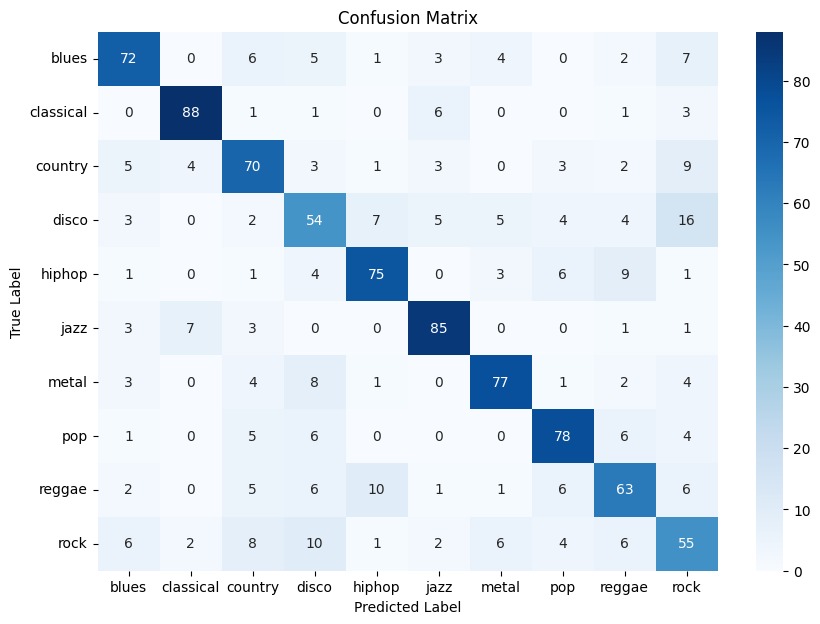

In [17]:
import os
import pandas as pd
import numpy as np
import random
import warnings
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# %% Load Data
# Parameters
DATASET_PATH = 'data/features_30_sec.csv'
GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
N_FOLDS = 5  # Number of folds for cross-validation

# Load data from CSV
def load_features_data(csv_path):
    # Load the CSV into a pandas DataFrame
    data = pd.read_csv(csv_path)
    
    # Drop the filename column if it exists
    if 'filename' in data.columns:
        data = data.drop(columns=['filename'])

    # Separate features (numerical columns) and target (genre)
    X = data.iloc[:, :-1]  # All columns except the last
    y = data.iloc[:, -1]   # The last column is assumed to be the genre label

    # Encode the labels to integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_categorical = to_categorical(y_encoded)

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return pd.DataFrame(X_scaled, columns=X.columns), y_categorical, label_encoder

# Perform feature correlation analysis and remove highly correlated features
def remove_highly_correlated_features(X, threshold=0.8):
    # Compute the correlation matrix
    corr_matrix = X.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"Removing highly correlated features: {to_drop}")
    
    # Drop the highly correlated features
    X = X.drop(columns=to_drop)
    return X

# Load and preprocess the data
X, y_categorical, label_encoder = load_features_data(DATASET_PATH)

# Remove highly correlated features
X = remove_highly_correlated_features(X)

# Convert DataFrame back to NumPy array
X = X.values

# K-fold Cross Validation setup
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# Store the validation scores for each fold
validation_accuracies = []
all_true_labels = []  # To store true labels from each fold
all_pred_labels = []  # To store predicted labels from each fold

# Loop over the splits/folds
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold+1}/{N_FOLDS}...")

    # Split the data for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_categorical[train_index], y_categorical[val_index]

    # Reshape data for CNN input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    # Build the CNN model
    model = models.Sequential([
        layers.Conv1D(64, kernel_size=5, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(GENRES), activation='softmax')
    ])

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model on the training data of this fold with learning rate scheduler
    def lr_scheduler(epoch, lr):
        if epoch % 10 == 0 and epoch != 0:
            lr = lr * 0.5
        return lr
    lr_callback = LearningRateScheduler(lr_scheduler)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[lr_callback], verbose=0)

    # Evaluate the model on the validation data of this fold
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy for fold {fold+1}: {val_accuracy:.4f}")

    # Store the validation accuracy for this fold
    validation_accuracies.append(val_accuracy)

    # Get predictions and store true/ predicted labels for confusion matrix
    y_pred = model.predict(X_val)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Get the class with the highest probability
    y_true_labels = np.argmax(y_val, axis=1)  # Get the true class labels (integer values)

    all_true_labels.extend(y_true_labels)
    all_pred_labels.extend(y_pred_labels)

# Calculate the average validation accuracy across all folds
average_val_accuracy = np.mean(validation_accuracies)
print(f"\nAverage Validation Accuracy across {N_FOLDS} folds: {average_val_accuracy:.4f}")

# Save the final model after training
model.save('music_genre_classifier.h5')
print("Model saved as 'music_genre_classifier.h5'")

# Generate the confusion matrix for all folds
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=GENRES, yticklabels=GENRES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
